In [11]:
import os, sys
import torch
import json
import h5py
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [12]:
image_file = json.load(open('../datasets/vg/image_data.json'))
vocab_file = json.load(open('../datasets/vg/VG-SGG-dicts.json'))
data_file = h5py.File('../datasets/vg/VG-SGG-with-attri.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [13]:
# load detected results
detected_origin_path = '../checkpoints/vctree-i1/vctree-precls-rwt-pretrain_L118relabel_osp/inference/VG_stanford_filtered_with_attribute_test/'
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [14]:
# get image info by index
def get_info_by_idx(idx, det_input, thres=0.5):
    groundtruth = det_input['groundtruths'][idx]
    prediction = det_input['predictions'][idx]
    # image path
    img_path = detected_info[idx]['img_file']
    # boxes
    boxes = groundtruth.bbox
    # object labels
    idx2label = vocab_file['idx_to_label']
    labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(groundtruth.get_field('labels').tolist())]
    pred_labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(prediction.get_field('pred_labels').tolist())]
    # groundtruth relation triplet
    idx2pred = vocab_file['idx_to_predicate']
    gt_rels = groundtruth.get_field('relation_tuple').tolist()
    gt_rels = [(labels[i[0]], idx2pred[str(i[2])], labels[i[1]]) for i in gt_rels]
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_scores')
    pred_rel_label[:,0] = 0
    pred_rel_score, pred_rel_label = pred_rel_label.max(-1)
    #mask = pred_rel_score > thres
    #pred_rel_score = pred_rel_score[mask]
    #pred_rel_label = pred_rel_label[mask]
    pred_rels = [(pred_labels[i[0]], idx2pred[str(j)], pred_labels[i[1]]) for i, j in zip(pred_rel_pair, pred_rel_label.tolist())]
    return img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label

In [30]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)

def print_list(name, input_list, score_list=None):
    if score_list is not None:
        for i, (item, score) in enumerate(zip(input_list, score_list)):
            print(name + ' ' + str(i) + ': ' + str(item) + ',' + str(round(score, 2)))
    else:
        for i, item in enumerate(input_list):
            print(name + ' ' + str(i) + ': ' + str(item))
    
def draw_image(img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label, print_img=True):
    if '/home/crf/johnathon_sgg_benchmark/Scene-Graph-Benchmark.pytorch' in img_path:
        img_path = img_path.replace('/home/crf/johnathon_sgg_benchmark/Scene-Graph-Benchmark.pytorch', '..')
    pic = Image.open(img_path)
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        info = labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    if print_img:
        display(pic)
    if print_img:
        print('*' * 50)
        print_list('gt_boxes', labels)
        print('*' * 50)
        print_list('gt_rels', gt_rels)
        print('*' * 50)
    print_list('pred_rels', pred_rels[:20], pred_rel_score[:20].numpy())
    print('*' * 50)
    
    return None

In [31]:
def show_selected(idx_list):
    for select_idx in idx_list:
        print(select_idx)
        draw_image(*get_info_by_idx(select_idx, detected_origin_result))
        
def show_all(start_idx, length):
    for cand_idx in range(start_idx, start_idx+length):
        print(cand_idx)
        draw_image(*get_info_by_idx(cand_idx, detected_origin_result))

0


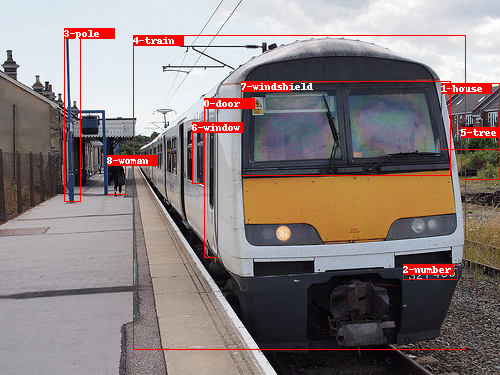

**************************************************
gt_boxes 0: 0-door
gt_boxes 1: 1-house
gt_boxes 2: 2-number
gt_boxes 3: 3-pole
gt_boxes 4: 4-train
gt_boxes 5: 5-tree
gt_boxes 6: 6-window
gt_boxes 7: 7-windshield
gt_boxes 8: 8-woman
**************************************************
gt_rels 0: ('7-windshield', 'on', '4-train')
gt_rels 1: ('6-window', 'on', '4-train')
gt_rels 2: ('4-train', 'has', '6-window')
gt_rels 3: ('1-house', 'near', '4-train')
gt_rels 4: ('5-tree', 'near', '1-house')
**************************************************
pred_rels 0: ('0-door', 'to', '4-train'),0.96
pred_rels 1: ('6-window', 'on back of', '4-train'),0.91
pred_rels 2: ('2-number', 'on back of', '4-train'),0.66
pred_rels 3: ('5-tree', 'over', '4-train'),0.58
pred_rels 4: ('1-house', 'behind', '4-train'),0.47
pred_rels 5: ('7-windshield', 'of', '4-train'),0.3
pred_rels 6: ('5-tree', 'in front of', '1-house'),0.2
pred_rels 7: ('0-door', 'between', '6-window'),0.19
pred_rels 8: ('8-woman', 'standing on'

In [32]:
show_all(start_idx=0, length=1)
#show_selected([119, 967, 713, 5224, 19681, 25371])